# `Setup`

In [161]:
# Library Import
import pandas as pd
import numpy as np
import os
if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
from utils.helpers import * # Import all helper functions
from utils.StatefarmPytorchDataset import StateFarmDataset # Import Pytorch dataset class
from IPython.display import display, clear_output, Image as ipyImage
from PIL import Image, ImageDraw, ImageFont
import random
import time
import cv2

# Printing current working directory
print(os.getcwd())

/Users/alexanderries/aml_itu


In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

### `Config`

In [163]:
# Loading the config file
config = load_config()
    
    
# Training Images
train_img = config['dataset']['images']['train']

# Outputting config    
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'}}

In [164]:
# Loading the data
df = pd.read_csv(config['dataset']['data'])

In [165]:
config['dataset']['class_mapping']

{'c0': 'safe driving',
 'c1': 'texting - right',
 'c2': 'talking on the phone - right',
 'c3': 'texting - left',
 'c4': 'talking on the phone - left',
 'c5': 'operating the radio',
 'c6': 'drinking',
 'c7': 'reaching behind',
 'c8': 'hair and makeup',
 'c9': 'talking to passenger'}

In [166]:
df['target'] = df['classname'].map(config['dataset']['class_mapping'])

## Data Exploration

The dataset contains 22424 rows and the 4 columns "subject", "classname", "img" and "target"

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
 3   target     22424 non-null  object
dtypes: object(4)
memory usage: 700.9+ KB


No duplicated images in the dataset

In [169]:
len(df.img.unique())

22424

In [170]:
df.head()

,subject,classname,img,target
0,p002,c0,img_44733.jpg,safe driving
1,p002,c0,img_72999.jpg,safe driving
2,p002,c0,img_25094.jpg,safe driving
3,p002,c0,img_69092.jpg,safe driving
4,p002,c0,img_92629.jpg,safe driving


Pictures were taken of 26 different persons ("subjects") in a car

In [171]:
len(df.subject.unique())

26

The driver's behaviour is classified in 10 different classes. We chose to add the column target for getting a better understanding of the classification while exlporing the data.

In [172]:
print(df.classname.unique())
print(df.target.unique())

['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
['safe driving' 'texting - right' 'talking on the phone - right'
 'texting - left' 'talking on the phone - left' 'operating the radio'
 'drinking' 'reaching behind' 'hair and makeup' 'talking to passenger']


There is a different number of images per subject.

Number of subjects:  26
Number of images per subject: 
subject
p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: count, dtype: int64


<Axes: xlabel='subject'>

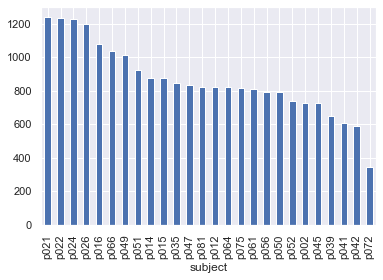

In [173]:
# Examine subject distribution
print('Number of subjects: ', df.subject.nunique())
print('Number of images per subject: ')
print(df.subject.value_counts())
df.subject.value_counts().plot(kind='bar')

The target labels are also not equally distributed.

Number of targets:  10
Number of images per target: 
target
safe driving                    2489
texting - left                  2346
talking on the phone - left     2326
drinking                        2325
talking on the phone - right    2317
operating the radio             2312
texting - right                 2267
talking to passenger            2129
reaching behind                 2002
hair and makeup                 1911
Name: count, dtype: int64


<Axes: xlabel='target'>

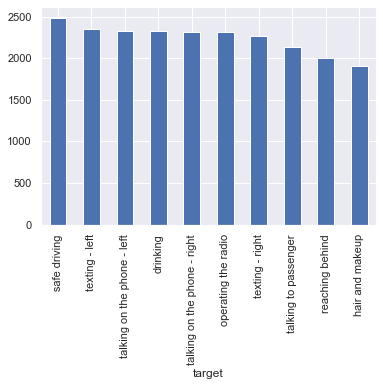

In [174]:
# Examine target distribution
print('Number of targets: ', df.target.nunique())
print('Number of images per target: ')
print(df.target.value_counts())
df.target.value_counts().plot(kind='bar')

The classes in the pictures follow most of the time the same distribution. It seems that all classes have similar proportions for every subject except p072 who has the least samples overall and a bad distribution of the classes. Except the subject p072, p050 and p014, it seems that **every subject has at least 50 images per class**.

Furthermore, it seems that the count of the classes "reaching behind" and "hair and makeup" is in many subjects a bit lower than others.

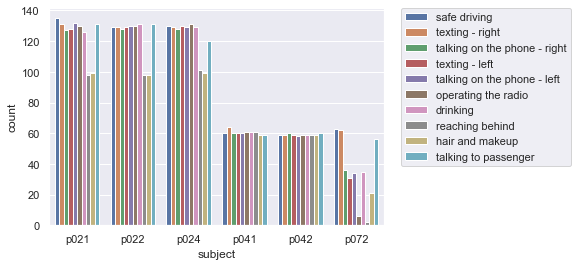

In [175]:
# Examine top 3 and bottom 3 subjects
top3 = df.subject.value_counts().index[:3]
bottom3 = df.subject.value_counts().index[-3:]
df_top_bottom = df[df.subject.isin(top3) | df.subject.isin(bottom3)]
sns.countplot(x='subject', hue='target', data=df_top_bottom)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

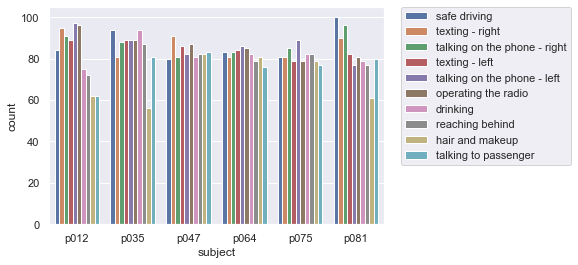

In [176]:
# Examine middle 6 subjects
middle6 = df.subject.value_counts().index[10:-10]
df_middle6 = df[df.subject.isin(middle6)]
sns.countplot(x='subject', hue='target', data=df_middle6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

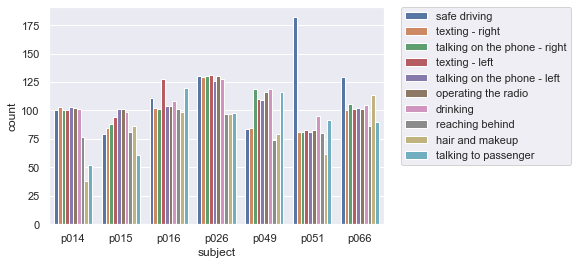

In [177]:
# Examine the rest of the subjects (excluding top 3, bottom 3, and middle 6)
rest = df.subject.value_counts().index[3:10]
df_rest = df[df.subject.isin(rest)]
sns.countplot(x='subject', hue='target', data=df_rest)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

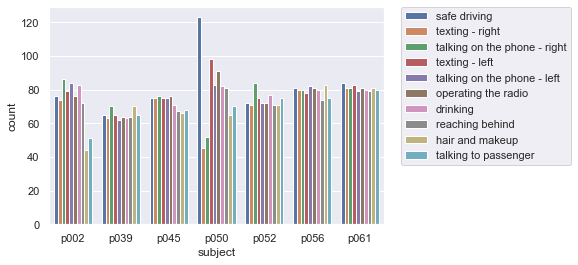

In [178]:
rest = df.subject.value_counts().index[-10:-3]
df_rest = df[df.subject.isin(rest)]
sns.countplot(x='subject', hue='target', data=df_rest)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Images Exploration

Look at all the subjects

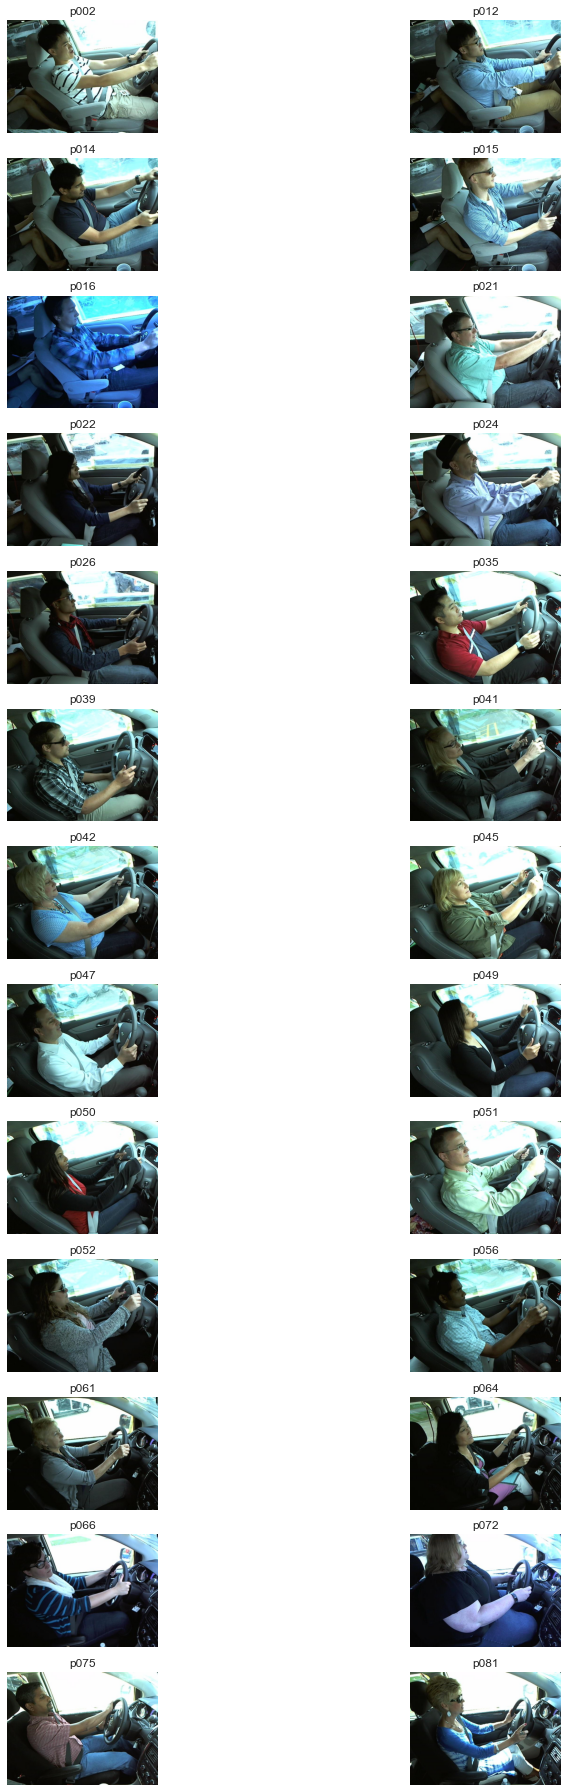

In [179]:
# filter one image of target safe driving from every subject
df_safe = df[df.target == 'safe driving'].groupby('subject').first().reset_index()

# Plotting the images
fig, axes = plt.subplots(13, 2, figsize=(15, 25))
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(train_img, df_safe.iloc[i].classname, df_safe.iloc[i].img))
    ax.imshow(img)
    ax.set_title(df_safe.iloc[i].subject)
    ax.axis('off')
fig.tight_layout()



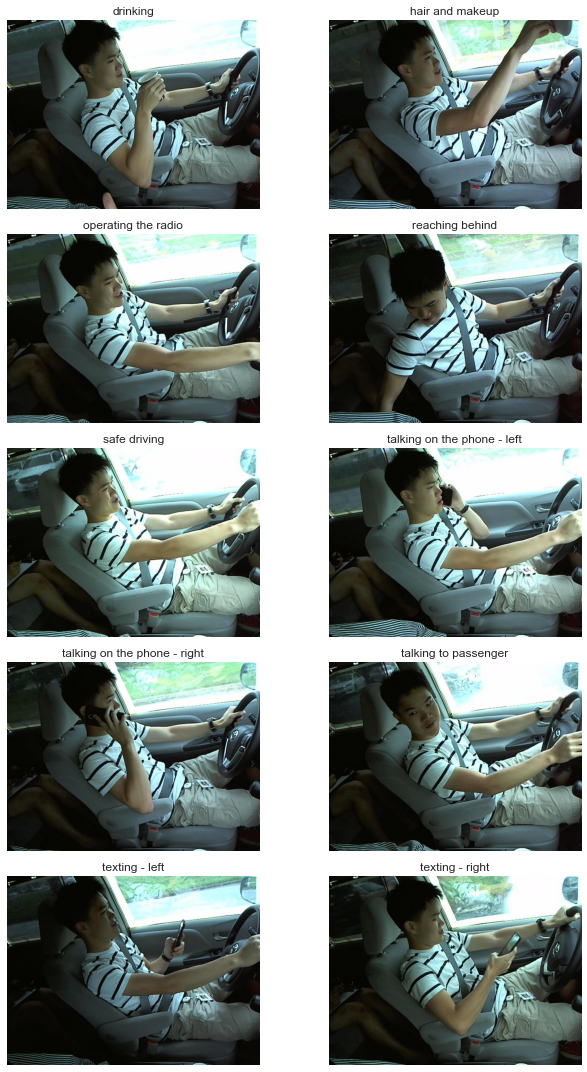

In [180]:
# filter for one image per target
df_unique = df.groupby('target').first().reset_index()

# Plotting the images
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(train_img, df_unique.iloc[i].classname, df_unique.iloc[i].img))
    ax.imshow(img)
    ax.set_title(df_unique.iloc[i].target)
    ax.axis('off')
fig.tight_layout()

## Grayscale Images and average the images by target

Idea from: https://arxiv.org/pdf/2204.03371.pdf

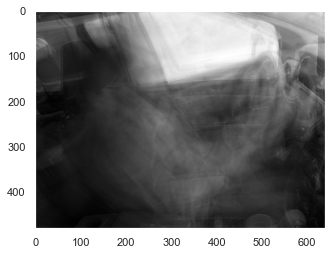

In [181]:
# filter for target safe driving
df_safe = df[df.target == 'safe driving']

# Convert all of this target's images to grayscale and save them in a list
images = []
for i in range(len(df_safe)):
    # open img as numpy array
    img = cv2.imread(os.path.join(train_img, df_safe.iloc[i].classname, df_safe.iloc[i].img))
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    images.append(gray_image)


# Average all images together and plot and remove the grid
avg_image_safedriving = np.mean(images, axis=0)
plt.imshow(avg_image_safedriving, cmap='gray')
plt.grid(False)

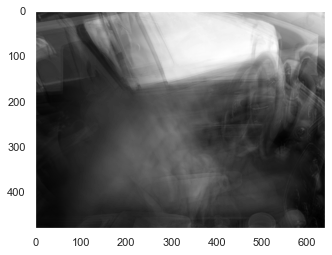

In [182]:
# filter for target reaching behind
df_reach = df[df.target == 'reaching behind']

# Convert all of this target's images to grayscale and save them in a list
images = []
for i in range(len(df_reach)):
    # open img as numpy array
    img = cv2.imread(os.path.join(train_img, df_reach.iloc[i].classname, df_reach.iloc[i].img))
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    images.append(gray_image)


# Average all images together and plot and remove the grid
avg_image_reachbehind = np.mean(images, axis=0)
plt.imshow(avg_image_reachbehind, cmap='gray')
plt.grid(False)

Compare average pictures of safe driving and reach behind

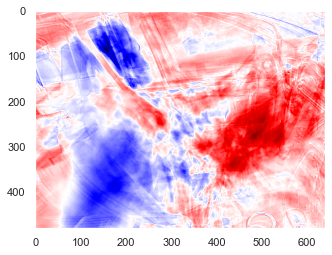

In [188]:
# build the difference image and plot with distinct color map
diff_image = avg_image_safedriving - avg_image_reachbehind
plt.imshow(diff_image, cmap='seismic')
plt.grid(False)

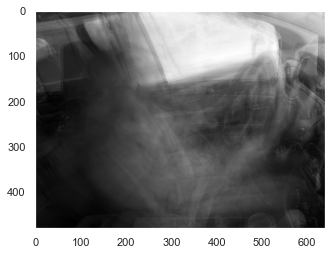

In [189]:
# filter for target reaching behind
df_talk = df[df.target == 'talking to passenger']

# Convert all of this target's images to grayscale and save them in a list
images = []
for i in range(len(df_talk)):
    # open img as numpy array
    img = cv2.imread(os.path.join(train_img, df_talk.iloc[i].classname, df_talk.iloc[i].img))
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    images.append(gray_image)


# Average all images together and plot and remove the grid
avg_image_talking = np.mean(images, axis=0)
plt.imshow(avg_image_talking, cmap='gray')
plt.grid(False)

As we can see, the difference between safe driving and reaching behind is higher than the difference between safe driving and talking to passenger, as the posture of the body is similar while driving. However there is still a difference near the steering wheel. Plotting sample images from the class talking to passenger tells us why: Many subjects do not have both hands on the steering wheel

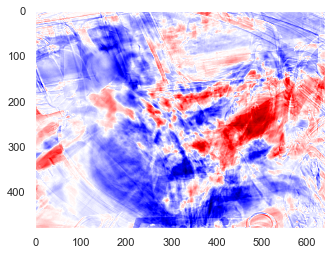

In [190]:
# build the difference image and plot with distinct color map
diff_image = avg_image_safedriving - avg_image_talking
plt.imshow(diff_image, cmap='seismic')
plt.grid(False)

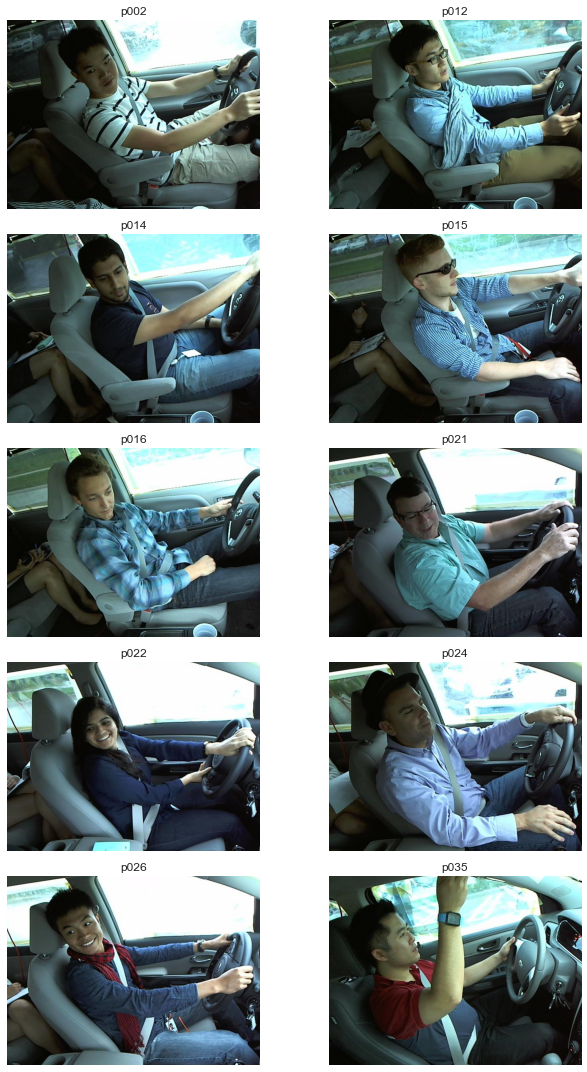

In [191]:
# filter for 10 images of target talking to passenger
df_talk = df[df.target == 'talking to passenger'].groupby('subject').first().reset_index()

# Plotting the images
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(train_img, df_talk.iloc[i].classname, df_talk.iloc[i].img))
    ax.imshow(img)
    ax.set_title(df_talk.iloc[i].subject)
    ax.axis('off')
fig.tight_layout()